<a href="https://colab.research.google.com/github/aauliariza/stroke-prediction/blob/main/project_kelompok.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

# Example: Move a tensor to GPU
x = torch.randn(2, 3)
print(f"Tensor on CPU:\n{x}")
x_gpu = x.to(device)
print(f"Tensor on {device}:\n{x_gpu}")

GPU is available: Tesla T4
Number of GPUs available: 1
Tensor on CPU:
tensor([[-1.0671,  1.2831,  1.3274],
        [-1.1090, -0.7764,  0.1323]])
Tensor on cuda:
tensor([[-1.0671,  1.2831,  1.3274],
        [-1.1090, -0.7764,  0.1323]], device='cuda:0')


In [2]:
print("Installing dependencies... This may take a few minutes.")
print("="*70)

!pip install pandas numpy scikit-learn xgboost imbalanced-learn matplotlib seaborn --quiet
print("Core ML libraries installed (pandas, numpy, scikit-learn, xgboost, imbalanced-learn, matplotlib, seaborn)")

!pip install pytorch-tabnet --quiet
print("PyTorch TabNet installed")

# Install CPU-only PyTorch (Windows) to avoid DLL/CUDA mismatches
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu --quiet
print("PyTorch CPU-only wheel installed")

Installing dependencies... This may take a few minutes.
Core ML libraries installed (pandas, numpy, scikit-learn, xgboost, imbalanced-learn, matplotlib, seaborn)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.8 MB/s eta 0:00:00
PyTorch TabNet installed
PyTorch CPU-only wheel installed


## 1. Import Libraries

In [3]:
import os
import glob
import zipfile
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Models
from sklearn.svm import SVC
from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"Random State: {RANDOM_STATE}")

All libraries imported successfully!
Random State: 42


## 2. Load Dataset

In [5]:
def load_data_from_path(filepath):
    print("\n" + "="*80)
    print("LOADING DATASET")
    print("="*80)

    # Ensure file exists
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # Check extension is CSV
    file_ext = os.path.splitext(filepath)[1].lower()
    if file_ext != '.csv':
        raise ValueError(f"Unsupported file format: {file_ext}. Please provide a .csv file.")

    # Read CSV
    df = pd.read_csv(filepath)
    print(f"\n✓ Dataset loaded: {os.path.basename(filepath)}")
    print(f"  Full path: {os.path.abspath(filepath)}")
    return df

In [6]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

try:
    df = pd.read_csv(df)
except:
    df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Display basic information
print(f"\nDataset Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
print("\n" + "="*70)
print("FIRST 5 ROWS:")
print("="*70)
display(df.head())

print("\n" + "="*70)
print("DATASET INFORMATION:")
print("="*70)
print(df.info())

print("\n" + "="*70)
print("STATISTICAL SUMMARY:")
print("="*70)
display(df.describe())


Dataset Shape: (5110, 12)
Rows: 5110, Columns: 12

FIRST 5 ROWS:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None

STATISTICAL SUMMARY:


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 3. Exploratory Data Analysis (EDA)

TARGET VARIABLE DISTRIBUTION (Stroke)
No Stroke (0): 4861 (95.13%)
Stroke (1): 249 (4.87%)

Class Imbalance Ratio: 1:19.52


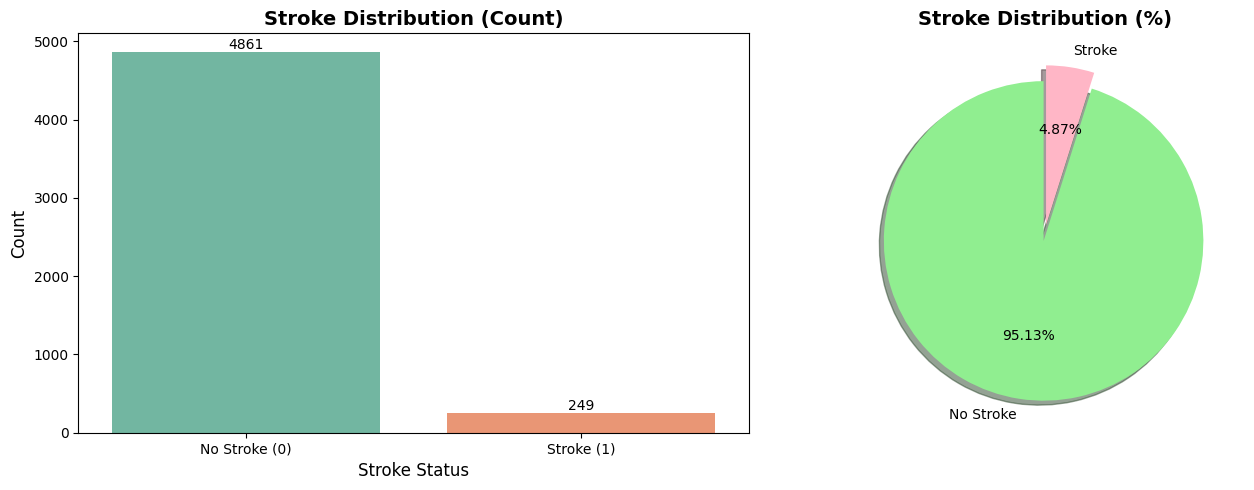


MISSING VALUES:


,Missing Count,Percentage
bmi,201,3.933464


In [7]:
# Class distribution
print("="*70)
print("TARGET VARIABLE DISTRIBUTION (Stroke)")
print("="*70)
stroke_counts = df['stroke'].value_counts()
stroke_percentages = df['stroke'].value_counts(normalize=True) * 100

print(f"No Stroke (0): {stroke_counts[0]} ({stroke_percentages[0]:.2f}%)")
print(f"Stroke (1): {stroke_counts[1]} ({stroke_percentages[1]:.2f}%)")
print(f"\nClass Imbalance Ratio: 1:{stroke_counts[0]/stroke_counts[1]:.2f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x='stroke', ax=axes[0], palette='Set2')
axes[0].set_title('Stroke Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['No Stroke (0)', 'Stroke (1)'])

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# Pie chart
colors = ['#90EE90', '#FFB6C6']
explode = (0.05, 0.05)
axes[1].pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.2f%%',
           colors=colors, explode=explode, shadow=True, startangle=90)
axes[1].set_title('Stroke Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Missing values
print("\n" + "="*70)
print("MISSING VALUES:")
print("="*70)
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    display(missing_df)
else:
    print("No missing values found!")

## 4. Feature Distribution Analysis

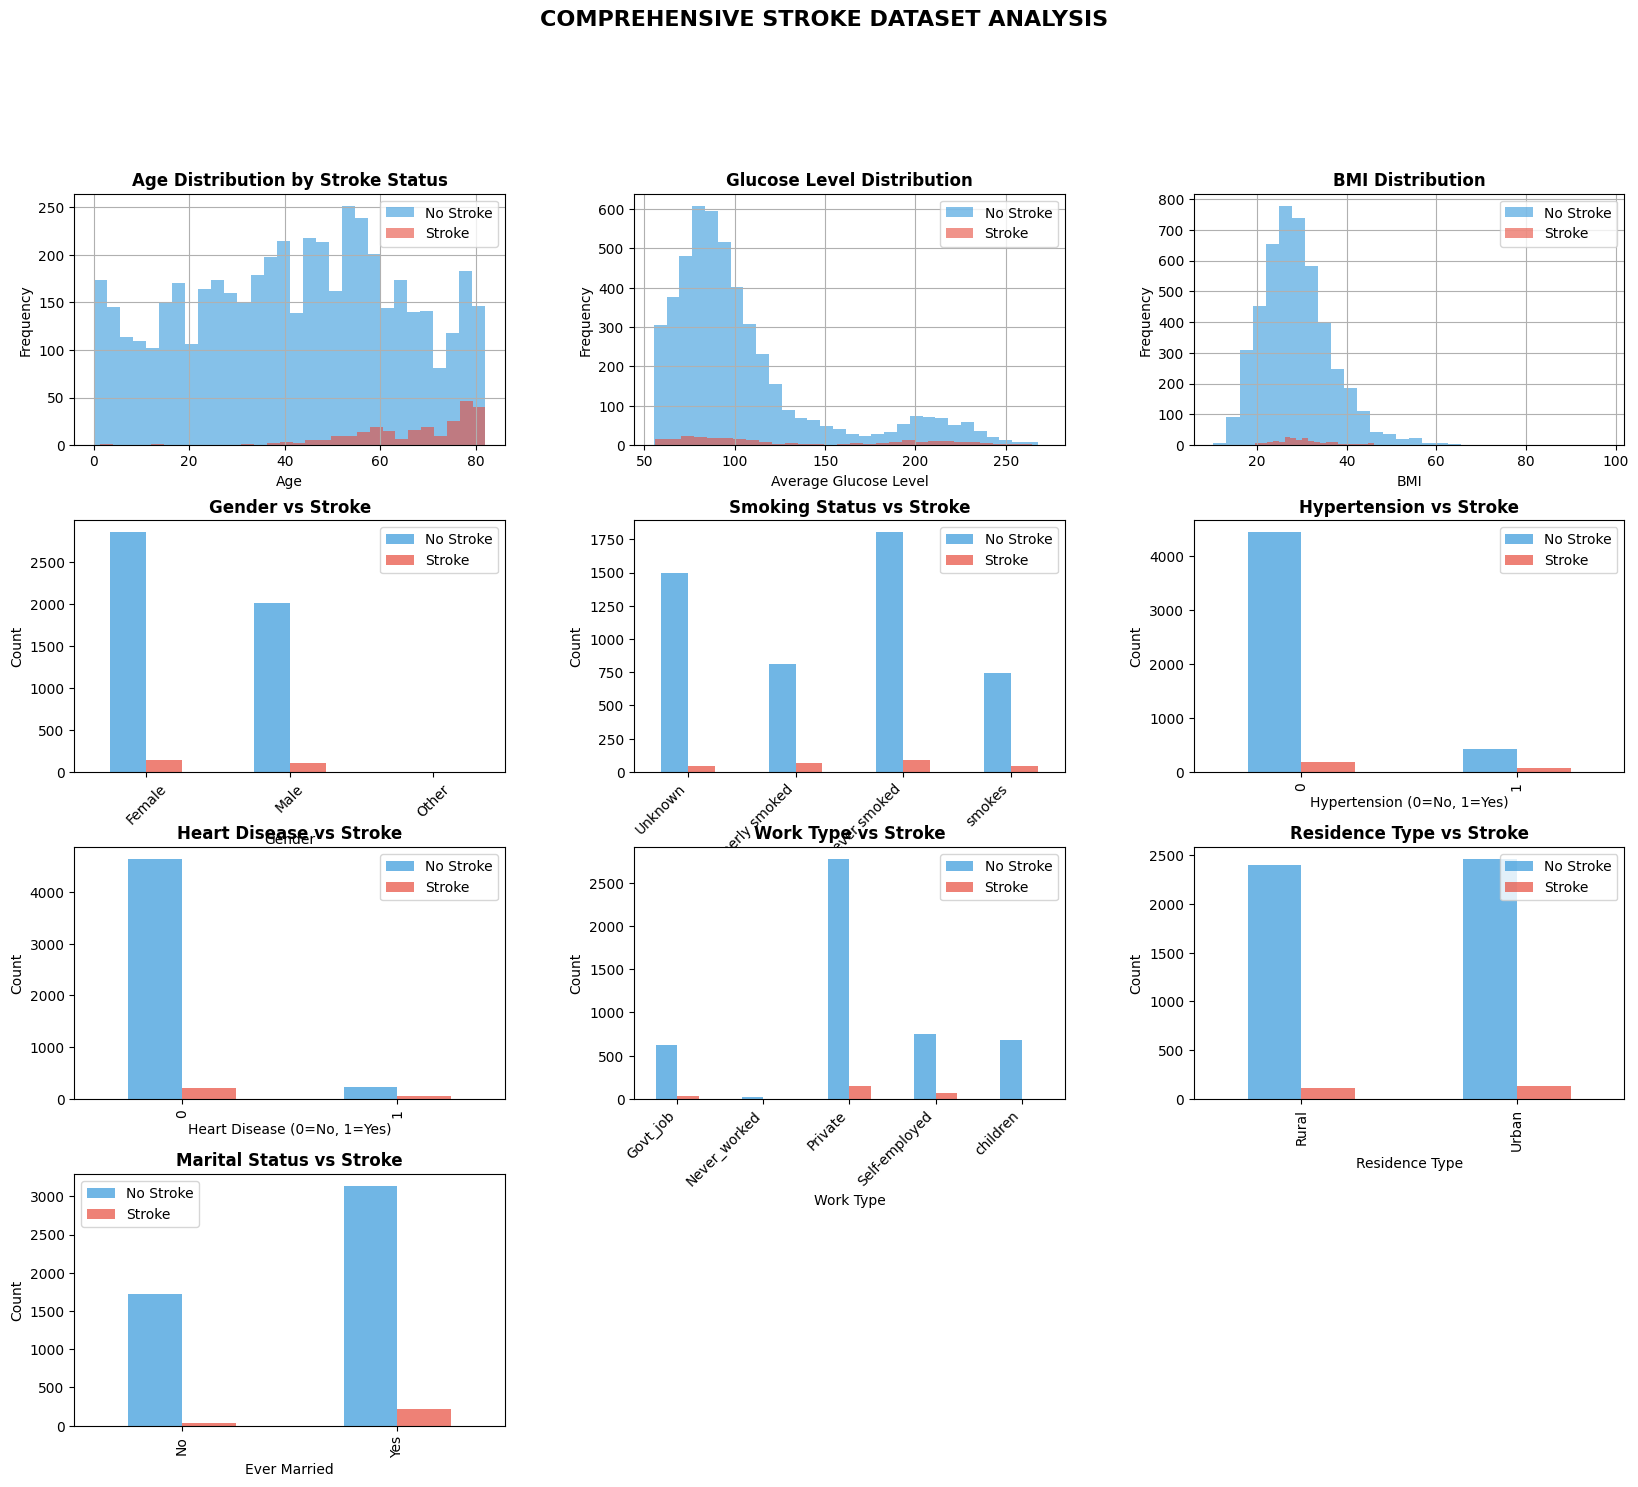

In [9]:
from matplotlib.gridspec import GridSpec

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

# 1. Age Distribution by Stroke
ax2 = fig.add_subplot(gs[0, 0])
df[df['stroke']==0]['age'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax2)
df[df['stroke']==1]['age'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax2)
ax2.set_title('Age Distribution by Stroke Status', fontsize=12, fontweight='bold')
ax2.set_xlabel('Age')
ax2.set_ylabel('Frequency')
ax2.legend()

# 2. Average Glucose Level Distribution
ax3 = fig.add_subplot(gs[0, 1])
df[df['stroke']==0]['avg_glucose_level'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax3)
df[df['stroke']==1]['avg_glucose_level'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax3)
ax3.set_title('Glucose Level Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Average Glucose Level')
ax3.set_ylabel('Frequency')
ax3.legend()

# 3. BMI Distribution
ax4 = fig.add_subplot(gs[0, 2])
df[df['stroke']==0]['bmi'].hist(bins=30, alpha=0.6, label='No Stroke', color='#3498db', ax=ax4)
df[df['stroke']==1]['bmi'].hist(bins=30, alpha=0.6, label='Stroke', color='#e74c3c', ax=ax4)
ax4.set_title('BMI Distribution', fontsize=12, fontweight='bold')
ax4.set_xlabel('BMI')
ax4.set_ylabel('Frequency')
ax4.legend()

# 4. Gender Distribution
ax5 = fig.add_subplot(gs[1, 0])
gender_stroke = pd.crosstab(df['gender'], df['stroke'])
gender_stroke.plot(kind='bar', ax=ax5, color=['#3498db', '#e74c3c'], alpha=0.7)
ax5.set_title('Gender vs Stroke', fontsize=12, fontweight='bold')
ax5.set_xlabel('Gender')
ax5.set_ylabel('Count')
ax5.legend(['No Stroke', 'Stroke'])
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)

# 5. Smoking Status
ax6 = fig.add_subplot(gs[1, 1])
smoking_stroke = pd.crosstab(df['smoking_status'], df['stroke'])
smoking_stroke.plot(kind='bar', ax=ax6, color=['#3498db', '#e74c3c'], alpha=0.7)
ax6.set_title('Smoking Status vs Stroke', fontsize=12, fontweight='bold')
ax6.set_xlabel('Smoking Status')
ax6.set_ylabel('Count')
ax6.legend(['No Stroke', 'Stroke'])
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, ha='right')

# 6. Hypertension
ax7 = fig.add_subplot(gs[1, 2])
hypertension_stroke = pd.crosstab(df['hypertension'], df['stroke'])
hypertension_stroke.plot(kind='bar', ax=ax7, color=['#3498db', '#e74c3c'], alpha=0.7)
ax7.set_title('Hypertension vs Stroke', fontsize=12, fontweight='bold')
ax7.set_xlabel('Hypertension (0=No, 1=Yes)')
ax7.set_ylabel('Count')
ax7.legend(['No Stroke', 'Stroke'])

# 7. Heart Disease
ax8 = fig.add_subplot(gs[2, 0])
heart_stroke = pd.crosstab(df['heart_disease'], df['stroke'])
heart_stroke.plot(kind='bar', ax=ax8, color=['#3498db', '#e74c3c'], alpha=0.7)
ax8.set_title('Heart Disease vs Stroke', fontsize=12, fontweight='bold')
ax8.set_xlabel('Heart Disease (0=No, 1=Yes)')
ax8.set_ylabel('Count')
ax8.legend(['No Stroke', 'Stroke'])

# 8. Work Type
ax9 = fig.add_subplot(gs[2, 1])
work_stroke = pd.crosstab(df['work_type'], df['stroke'])
work_stroke.plot(kind='bar', ax=ax9, color=['#3498db', '#e74c3c'], alpha=0.7)
ax9.set_title('Work Type vs Stroke', fontsize=12, fontweight='bold')
ax9.set_xlabel('Work Type')
ax9.set_ylabel('Count')
ax9.legend(['No Stroke', 'Stroke'])
ax9.set_xticklabels(ax9.get_xticklabels(), rotation=45, ha='right')

# 9. Residence Type
ax10 = fig.add_subplot(gs[2, 2])
residence_stroke = pd.crosstab(df['Residence_type'], df['stroke'])
residence_stroke.plot(kind='bar', ax=ax10, color=['#3498db', '#e74c3c'], alpha=0.7)
ax10.set_title('Residence Type vs Stroke', fontsize=12, fontweight='bold')
ax10.set_xlabel('Residence Type')
ax10.set_ylabel('Count')
ax10.legend(['No Stroke', 'Stroke'])

# 10. Ever Married
ax11 = fig.add_subplot(gs[3, 0])
married_stroke = pd.crosstab(df['ever_married'], df['stroke'])
married_stroke.plot(kind='bar', ax=ax11, color=['#3498db', '#e74c3c'], alpha=0.7)
ax11.set_title('Marital Status vs Stroke', fontsize=12, fontweight='bold')
ax11.set_xlabel('Ever Married')
ax11.set_ylabel('Count')
ax11.legend(['No Stroke', 'Stroke'])

plt.suptitle('COMPREHENSIVE STROKE DATASET ANALYSIS', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

### a. Handling Missing Values & Outliers

In [10]:
# Create a copy for preprocessing
df_processed = df.copy()

print("="*70)
print("STEP 1: HANDLING MISSING VALUES")
print("="*70)

# Remove 'id' column as it's not useful for prediction
if 'id' in df_processed.columns:
    df_processed = df_processed.drop('id', axis=1)
    print("Removed 'id' column")

# Handle gender 'Other' (only 1 record based on paper)
print(f"\nGender value counts before cleaning:")
print(df_processed['gender'].value_counts())

df_processed = df_processed[df_processed['gender'] != 'Other']
print(f"Removed {len(df[df['gender'] == 'Other'])} record(s) with gender='Other'")

# Handle BMI missing values using median imputation (as per papers)
bmi_median = df_processed['bmi'].median()
print(f"\nBMI missing values: {df_processed['bmi'].isnull().sum()}")
print(f"BMI median value: {bmi_median:.2f}")

df_processed['bmi'].fillna(bmi_median, inplace=True)
print(f"Filled BMI missing values with median")

# Verify no missing values remain
print(f"\nTotal missing values after cleaning: {df_processed.isnull().sum().sum()}")

STEP 1: HANDLING MISSING VALUES
Removed 'id' column

Gender value counts before cleaning:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64
Removed 1 record(s) with gender='Other'

BMI missing values: 201
BMI median value: 28.10
Filled BMI missing values with median

Total missing values after cleaning: 0


In [11]:
print("\n" + "="*70)
print("STEP 2: HANDLING OUTLIERS")
print("="*70)

# Handle outliers using IQR method (as mentioned in papers)
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()

    # Cap outliers instead of removing (to preserve data)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

    return df, outliers_count

numerical_features = ['age', 'avg_glucose_level', 'bmi']
outlier_summary = {}

for feature in numerical_features:
    df_processed, outliers = remove_outliers_iqr(df_processed, feature)
    outlier_summary[feature] = outliers
    print(f"{feature}: {outliers} outliers capped")

print(f"\nOutliers handled using IQR capping method")
print(f"Final dataset shape: {df_processed.shape}")


STEP 2: HANDLING OUTLIERS
age: 0 outliers capped
avg_glucose_level: 627 outliers capped
bmi: 126 outliers capped

Outliers handled using IQR capping method
Final dataset shape: (5109, 11)


### b. Feature Encoding

In [12]:
print("="*70)
print("STEP 3: FEATURE ENCODING")
print("="*70)

# Separate features and target
X = df_processed.drop('stroke', axis=1)
y = df_processed['stroke']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

# Identify categorical and numerical features
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
numerical_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

print(f"\nCategorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# Create a copy for encoding
X_encoded = X.copy()

# Binary encoding for binary categorical features
print("\n1️.Binary Encoding:")
binary_mappings = {
    'gender': {'Male': 1, 'Female': 0},
    'ever_married': {'Yes': 1, 'No': 0},
    'Residence_type': {'Urban': 1, 'Rural': 0}
}

for feature, mapping in binary_mappings.items():
    X_encoded[feature] = X_encoded[feature].map(mapping)
    print(f"{feature}: {mapping}")

# One-hot encoding for multi-category features
print("\n2.One-Hot Encoding:")
X_encoded = pd.get_dummies(X_encoded, columns=['work_type', 'smoking_status'],
                           drop_first=False, dtype=int)

print(f"work_type and smoking_status encoded")
print(f"\nFinal encoded features shape: {X_encoded.shape}")
print(f"Total features after encoding: {len(X_encoded.columns)}")
print(f"\nEncoded feature names:")
print(list(X_encoded.columns))

# Display sample of encoded data
print("\n" + "="*70)
print("SAMPLE OF ENCODED DATA:")
print("="*70)
display(X_encoded.head())

STEP 3: FEATURE ENCODING
Features shape: (5109, 10)
Target shape: (5109,)

Features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']

Categorical features: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Numerical features: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

1️.Binary Encoding:
gender: {'Male': 1, 'Female': 0}
ever_married: {'Yes': 1, 'No': 0}
Residence_type: {'Urban': 1, 'Rural': 0}

2.One-Hot Encoding:
work_type and smoking_status encoded

Final encoded features shape: (5109, 17)
Total features after encoding: 17

Encoded feature names:
['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smok

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,169.365,36.6,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,169.365,28.1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.920,32.5,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,169.365,34.4,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,169.365,24.0,0,0,0,1,0,0,0,1,0


## 6. Train-Validation-Test Split

In [13]:
print("="*70)
print("STEP 4: DATA SPLITTING")
print("="*70)

# First split: 70% train, 30% temp (for validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded, y,
    test_size=0.30,
    random_state=RANDOM_STATE,
    stratify=y  # Maintain class distribution
)

# Second split: Split temp into 20% validation and 10% test from original dataset (2/3 val, 1/3 test from X_temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3, # 10% of total dataset (1/3 of 30% temp set)
    random_state=RANDOM_STATE,
    stratify=y_temp
)

print(f"Training set:   {X_train.shape[0]} samples ({X_train.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_encoded)*100:.1f}%)")
print(f"Test set:       {X_test.shape[0]} samples ({X_test.shape[0]/len(X_encoded)*100:.1f}%)")

# Check class distribution in each set
print("\n" + "="*70)
print("CLASS DISTRIBUTION:")
print("="*70)

def print_class_distribution(y, set_name):
    counts = y.value_counts()
    percentages = y.value_counts(normalize=True) * 100
    print(f"\n{set_name}:")
    print(f"  No Stroke (0): {counts[0]} ({percentages[0]:.2f}%)")
    print(f"  Stroke (1):    {counts[1]} ({percentages[1]:.2f}%)")

print_class_distribution(y_train, "Training Set")
print_class_distribution(y_val, "Validation Set")
print_class_distribution(y_test, "Test Set")

print("\nData split completed with stratification!")

STEP 4: DATA SPLITTING
Training set:   3576 samples (70.0%)
Validation set: 1022 samples (20.0%)
Test set:       511 samples (10.0%)

CLASS DISTRIBUTION:

Training Set:
  No Stroke (0): 3402 (95.13%)
  Stroke (1):    174 (4.87%)

Validation Set:
  No Stroke (0): 972 (95.11%)
  Stroke (1):    50 (4.89%)

Test Set:
  No Stroke (0): 486 (95.11%)
  Stroke (1):    25 (4.89%)

Data split completed with stratification!


## 7. Feature Scaling

In [14]:
print("="*70)
print("STEP 5: FEATURE SCALING")
print("="*70)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit on training data only and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Feature scaling completed using StandardScaler")
print(f"   - Mean = 0, Standard Deviation = 1")
print(f"\nScaled features shape: {X_train_scaled.shape}")

# Verify scaling
print("\n" + "="*70)
print("SCALING VERIFICATION (Training Set):")
print("="*70)
print(f"Mean values (should be ~0):")
print(X_train_scaled.mean().round(6).head())
print(f"\nStd values (should be ~1):")
print(X_train_scaled.std().round(6).head())

print("\nSample of scaled data:")
display(X_train_scaled.head())

STEP 5: FEATURE SCALING
Feature scaling completed using StandardScaler
   - Mean = 0, Standard Deviation = 1

Scaled features shape: (3576, 17)

SCALING VERIFICATION (Training Set):
Mean values (should be ~0):
gender          -0.0
age              0.0
hypertension     0.0
heart_disease    0.0
ever_married     0.0
dtype: float64

Std values (should be ~1):
gender           1.00014
age              1.00014
hypertension     1.00014
heart_disease    1.00014
ever_married     1.00014
dtype: float64

Sample of scaled data:


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4876,-0.842240,0.165303,-0.319911,-0.24404,0.720497,0.992756,-0.038652,-0.674030,-0.379413,-0.064902,0.874674,-0.444058,-0.401297,-0.659103,-0.462438,-0.769522,2.389392
4258,-0.842240,0.077127,-0.319911,-0.24404,0.720497,0.992756,-0.539394,0.099721,-0.379413,-0.064902,-1.143283,2.251956,-0.401297,1.517214,-0.462438,-0.769522,-0.418517
3137,1.187309,-1.465950,-0.319911,-0.24404,-1.387930,0.992756,-0.912663,-0.448939,-0.379413,-0.064902,-1.143283,-0.444058,2.491922,1.517214,-0.462438,-0.769522,-0.418517
4153,1.187309,1.576116,3.125873,-0.24404,0.720497,0.992756,-0.871798,-0.702167,-0.379413,-0.064902,-1.143283,2.251956,-0.401297,-0.659103,2.162450,-0.769522,-0.418517
3176,1.187309,-0.187400,-0.319911,-0.24404,0.720497,-1.007297,-0.501579,-0.069098,-0.379413,-0.064902,0.874674,-0.444058,-0.401297,-0.659103,-0.462438,-0.769522,2.389392


## 8. Handle Class Imbalance with SMOTE

STEP 6: HANDLING CLASS IMBALANCE WITH SMOTE
BEFORE SMOTE:
Training set class distribution:
stroke
0    3402
1     174
Name: count, dtype: int64

Imbalance ratio: 1:19.55

AFTER SMOTE:
Training set class distribution:
stroke
0    3402
1    3402
Name: count, dtype: int64

New balance ratio: 1:1.00

SMOTE applied successfully!
Training set size increased from 3576 to 6804


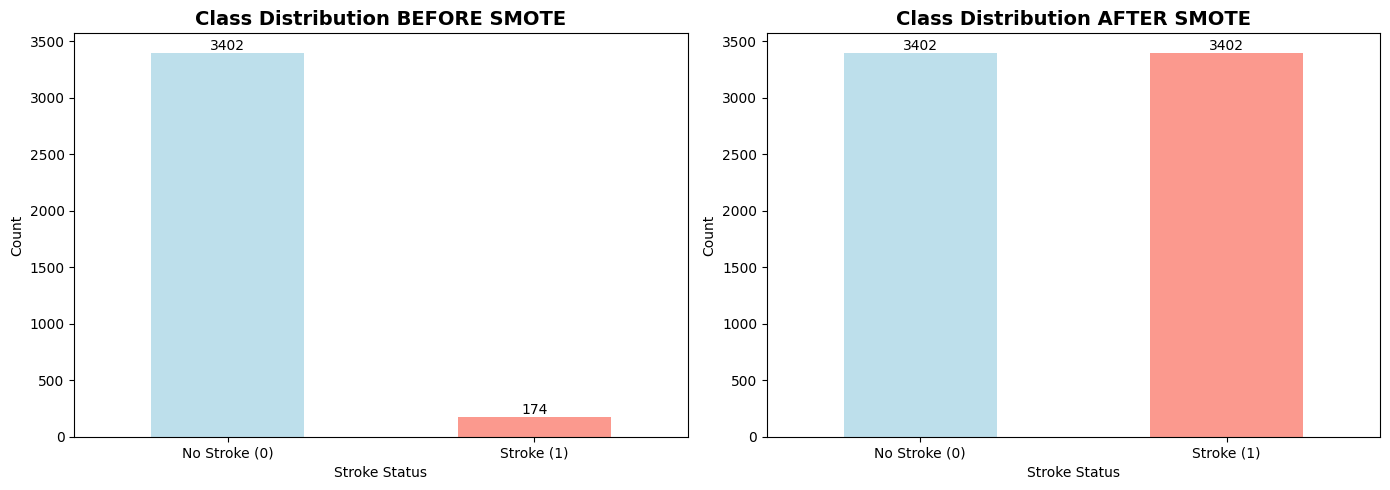


Note: SMOTE is applied ONLY to training data
Validation and test sets remain with original distribution


In [15]:
print("="*70)
print("STEP 6: HANDLING CLASS IMBALANCE WITH SMOTE")
print("="*70)

# Display original class distribution
print("BEFORE SMOTE:")
print(f"Training set class distribution:")
print(y_train.value_counts())
print(f"\nImbalance ratio: 1:{(y_train.value_counts()[0]/y_train.value_counts()[1]):.2f}")

# Apply SMOTE only on training data
smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print("\n" + "="*70)
print("AFTER SMOTE:")
print("="*70)
print(f"Training set class distribution:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\nNew balance ratio: 1:{(pd.Series(y_train_balanced).value_counts()[0]/pd.Series(y_train_balanced).value_counts()[1]):.2f}")

print(f"\nSMOTE applied successfully!")
print(f"Training set size increased from {len(X_train_scaled)} to {len(X_train_balanced)}")

# Visualize before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE
y_train.value_counts().plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'], alpha=0.8)
axes[0].set_title('Class Distribution BEFORE SMOTE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke Status')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Stroke (0)', 'Stroke (1)'], rotation=0)

for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%d')

# After SMOTE
pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=axes[1], color=['lightblue', 'salmon'], alpha=0.8)
axes[1].set_title('Class Distribution AFTER SMOTE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Stroke Status')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(['No Stroke (0)', 'Stroke (1)'], rotation=0)

for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

# Note: Validation and test sets are NOT oversampled
print("\nNote: SMOTE is applied ONLY to training data")
print("Validation and test sets remain with original distribution")

## 9. Model Machine Learning

### a. Support Vector Machine (SVM)

MODEL 1: SUPPORT VECTOR MACHINE (SVM)

Hyperparameter Grid:
   C: [0.1, 1, 10]
   kernel: ['rbf', 'linear']
   gamma: ['scale', 'auto', 0.1, 1]

Performing Grid Search with 10-Fold Cross-Validation...
This may take several minutes...
Fitting 10 folds for each of 24 candidates, totalling 240 fits

BEST HYPERPARAMETERS:
   C: 10
   gamma: 1
   kernel: rbf

Best F1-Score (CV): 0.9598

VALIDATION SET PERFORMANCE:
Accuracy: 0.9031
Precision: 0.0984
Recall: 0.1200
F1-Score: 0.1081
ROC-AUC: 0.6369

Confusion Matrix:
[[917  55]
 [ 44   6]]


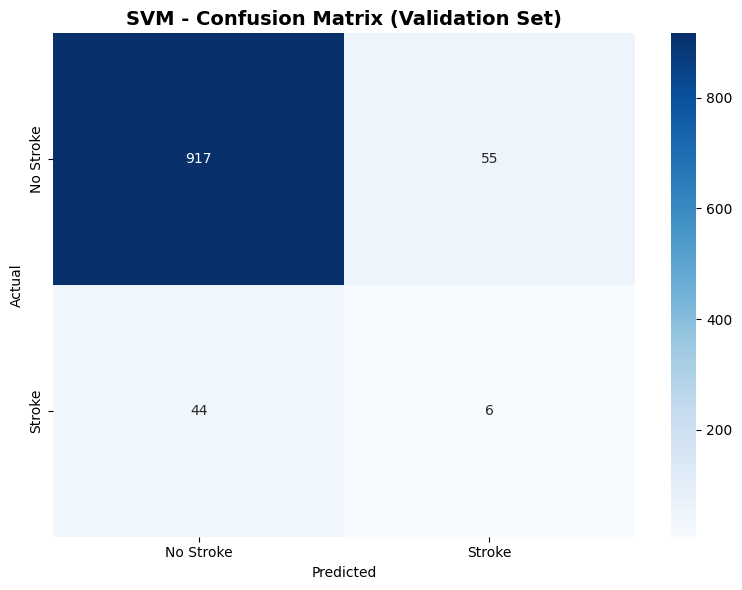


SVM model training and evaluation completed!


In [18]:
print("="*70)
print("MODEL 1: SUPPORT VECTOR MACHINE (SVM)")
print("="*70)

# Define hyperparameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

print("\nHyperparameter Grid:")
for param, values in svm_param_grid.items():
    print(f"   {param}: {values}")

# Initialize SVM
svm_model = SVC(random_state=RANDOM_STATE, probability=True)

# Perform Grid Search with Cross-Validation
print("\nPerforming Grid Search with 10-Fold Cross-Validation...")
print("This may take several minutes...")

svm_grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_param_grid,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
svm_grid_search.fit(X_train_balanced, y_train_balanced)

# Get best model
best_svm = svm_grid_search.best_estimator_

print("\n" + "="*70)
print("BEST HYPERPARAMETERS:")
print("="*70)
for param, value in svm_grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nBest F1-Score (CV): {svm_grid_search.best_score_:.4f}")

# Predictions on validation set
y_val_pred_svm = best_svm.predict(X_val_scaled)
y_val_pred_proba_svm = best_svm.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics on validation set
svm_metrics = {
    'Model': 'SVM',
    'Accuracy': accuracy_score(y_val, y_val_pred_svm),
    'Precision': precision_score(y_val, y_val_pred_svm),
    'Recall': recall_score(y_val, y_val_pred_svm),
    'F1-Score': f1_score(y_val, y_val_pred_svm),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_svm)
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in svm_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_val, y_val_pred_svm)
print("\nConfusion Matrix:")
print(cm_svm)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('SVM - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\nSVM model training and evaluation completed!")

### b. TabNet

MODEL 2: TABNET

TabNet Hyperparameters:
   n_d: 32
   n_a: 32
   n_steps: 3
   gamma: 1.3
   n_independent: 2
   n_shared: 2
   lambda_sparse: 0.001
   optimizer_fn: <class 'torch.optim.adam.Adam'>
   optimizer_params: {'lr': 0.02}
   mask_type: sparsemax
   scheduler_params: {'step_size': 10, 'gamma': 0.9}
   scheduler_fn: <class 'torch.optim.lr_scheduler.StepLR'>
   seed: 42
   verbose: 1

Training TabNet model...
This may take several minutes...
epoch 0  | loss: 0.57936 | validation_auc: 0.78873 |  0:00:00s
epoch 1  | loss: 0.43384 | validation_auc: 0.79932 |  0:00:01s
epoch 2  | loss: 0.41383 | validation_auc: 0.82679 |  0:00:01s
epoch 3  | loss: 0.39939 | validation_auc: 0.7818  |  0:00:02s
epoch 4  | loss: 0.3875  | validation_auc: 0.78141 |  0:00:03s
epoch 5  | loss: 0.39062 | validation_auc: 0.80162 |  0:00:03s
epoch 6  | loss: 0.39683 | validation_auc: 0.79055 |  0:00:04s
epoch 7  | loss: 0.38376 | validation_auc: 0.75497 |  0:00:04s
epoch 8  | loss: 0.3714  | validation_auc:

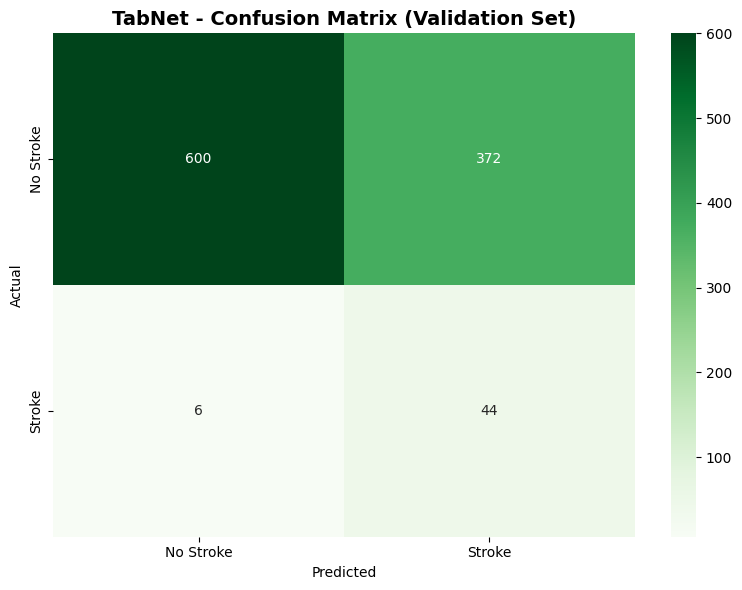


FEATURE IMPORTANCE (TabNet):
                           Feature  Importance
1                              age    0.436426
14  smoking_status_formerly smoked    0.084560
12              work_type_children    0.074981
3                    heart_disease    0.074739
6                avg_glucose_level    0.069410
7                              bmi    0.060488
15     smoking_status_never smoked    0.059626
5                   Residence_type    0.028259
4                     ever_married    0.022008
11         work_type_Self-employed    0.017984


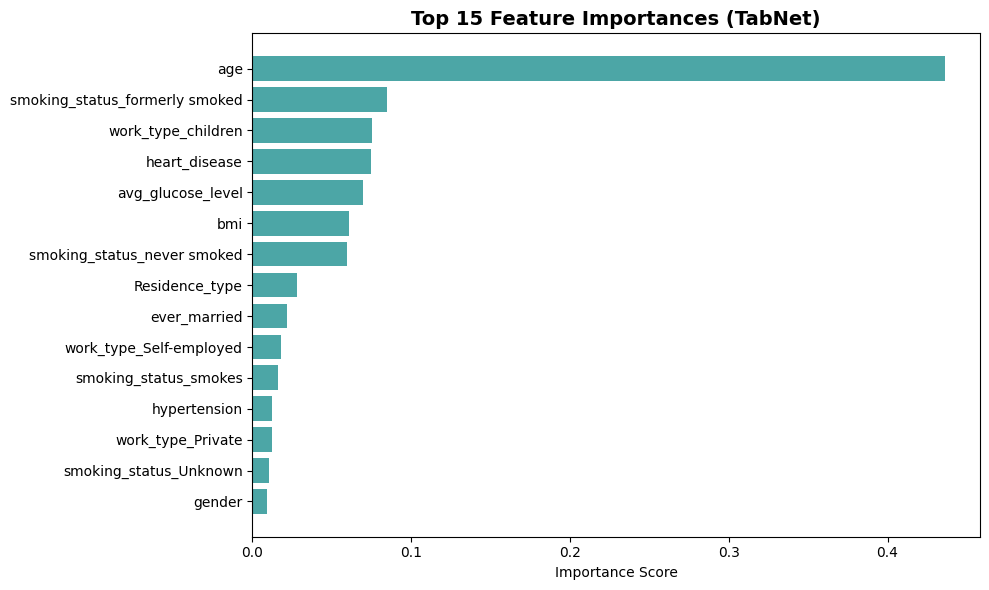


TabNet model training and evaluation completed!


In [26]:
print("="*70)
print("MODEL 2: TABNET")
print("="*70)

import torch.optim # Import torch.optim for the optimizer function

# Define TabNet hyperparameters based on paper recommendations
tabnet_params = {
    'n_d': 32,  # Decision layer dimension
    'n_a': 32,  # Attention layer dimension
    'n_steps': 3,
    'gamma': 1.3,
    'n_independent': 2,
    'n_shared': 2,
    'lambda_sparse': 1e-3,
    'optimizer_fn': torch.optim.Adam, # Changed from 'adam' to torch.optim.Adam
    'optimizer_params': dict(lr=2e-2),
    'mask_type': 'sparsemax',
    'scheduler_params': {"step_size": 10, "gamma": 0.9},
    'scheduler_fn': torch.optim.lr_scheduler.StepLR, # Also correcting scheduler_fn if it's a string
    'seed': RANDOM_STATE,
    'verbose': 1
}

print("\nTabNet Hyperparameters:")
for param, value in tabnet_params.items():
    print(f"   {param}: {value}")

# Initialize TabNet
tabnet_model = TabNetClassifier(**tabnet_params)

# Convert data to numpy arrays for TabNet
X_train_np = X_train_balanced.values
y_train_np = y_train_balanced.values
X_val_np = X_val_scaled.values
y_val_np = y_val.values

print("\nTraining TabNet model...")
print("This may take several minutes...")

# Train TabNet with early stopping
tabnet_model.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['validation'],
    eval_metric=['auc'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

print("\nTabNet training completed!")

# Predictions on validation set
y_val_pred_tabnet = tabnet_model.predict(X_val_np)
y_val_pred_proba_tabnet = tabnet_model.predict_proba(X_val_np)[:, 1]

# Calculate metrics
tabnet_metrics = {
    'Model': 'TabNet',
    'Accuracy': accuracy_score(y_val, y_val_pred_tabnet),
    'Precision': precision_score(y_val, y_val_pred_tabnet),
    'Recall': recall_score(y_val, y_val_pred_tabnet),
    'F1-Score': f1_score(y_val, y_val_pred_tabnet),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_tabnet)
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in tabnet_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_tabnet = confusion_matrix(y_val, y_val_pred_tabnet)
print("\nConfusion Matrix:")
print(cm_tabnet)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tabnet, annot=True, fmt='d', cmap='Greens', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('TabNet - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (TabNet):")
print("="*70)

feature_importances = tabnet_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances (TabNet)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTabNet model training and evaluation completed!")

### c. XGBoost

MODEL 3: XGBOOST

Hyperparameter Grid:
   learning_rate: [0.01, 0.05, 0.1]
   max_depth: [3, 5, 7]
   n_estimators: [100, 200, 300]
   subsample: [0.7, 0.8, 1.0]
   colsample_bytree: [0.7, 0.8, 1.0]
   min_child_weight: [1, 3, 5]

Performing Randomized Search with 10-Fold Cross-Validation...
This may take several minutes...
Fitting 10 folds for each of 50 candidates, totalling 500 fits

BEST HYPERPARAMETERS:
   subsample: 0.8
   n_estimators: 300
   min_child_weight: 1
   max_depth: 7
   learning_rate: 0.1
   colsample_bytree: 1.0

Best F1-Score (CV): 0.9588

VALIDATION SET PERFORMANCE:
Accuracy: 0.9139
Precision: 0.1042
Recall: 0.1000
F1-Score: 0.1020
ROC-AUC: 0.7780

Confusion Matrix:
[[929  43]
 [ 45   5]]


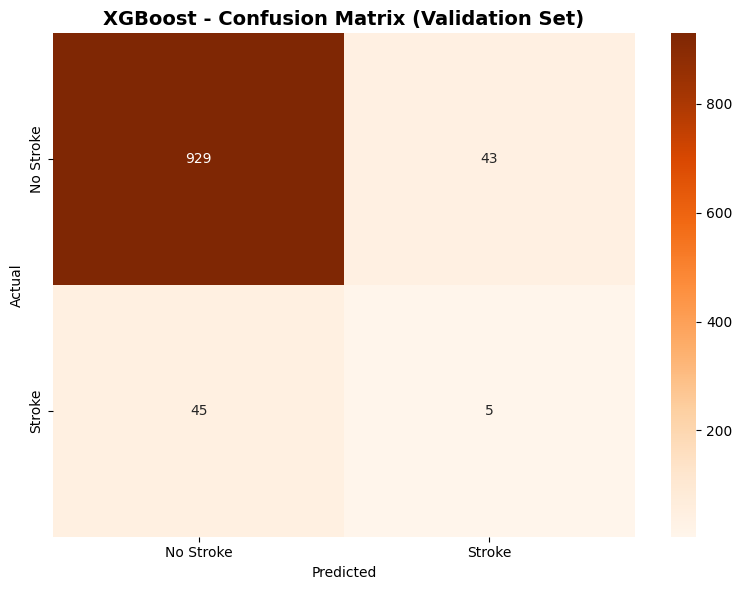


FEATURE IMPORTANCE (XGBoost):
                   Feature  Importance
1                      age    0.119618
0                   gender    0.111980
12      work_type_children    0.110230
5           Residence_type    0.100221
4             ever_married    0.083482
16   smoking_status_smokes    0.055542
10       work_type_Private    0.052151
13  smoking_status_Unknown    0.048623
2             hypertension    0.047450
8       work_type_Govt_job    0.044874


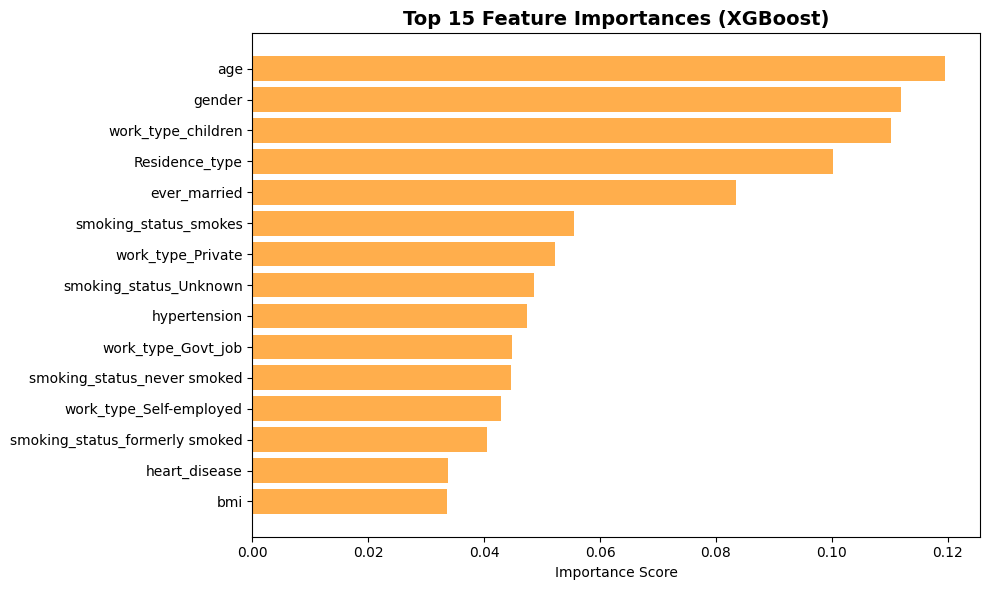


XGBoost model training and evaluation completed!


In [22]:
print("="*70)
print("MODEL 3: XGBOOST")
print("="*70)

# Define hyperparameter grid for XGBoost
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

print("\nHyperparameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"   {param}: {values}")

# Initialize XGBoost
xgb_model = XGBClassifier(
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Perform Grid Search (using RandomizedSearchCV for faster computation)
from sklearn.model_selection import RandomizedSearchCV

print("\nPerforming Randomized Search with 10-Fold Cross-Validation...")
print("This may take several minutes...")

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# Fit on training data
xgb_random_search.fit(X_train_balanced, y_train_balanced)

# Get best model
best_xgb = xgb_random_search.best_estimator_

print("\n" + "="*70)
print("BEST HYPERPARAMETERS:")
print("="*70)
for param, value in xgb_random_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nBest F1-Score (CV): {xgb_random_search.best_score_:.4f}")

# Predictions on validation set
y_val_pred_xgb = best_xgb.predict(X_val_scaled)
y_val_pred_proba_xgb = best_xgb.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
xgb_metrics = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_score(y_val, y_val_pred_xgb),
    'Precision': precision_score(y_val, y_val_pred_xgb),
    'Recall': recall_score(y_val, y_val_pred_xgb),
    'F1-Score': f1_score(y_val, y_val_pred_xgb),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_xgb)
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in xgb_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix:")
print(cm_xgb)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('XGBoost - Confusion Matrix (Validation Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Feature Importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (XGBoost):")
print("="*70)

feature_importances_xgb = best_xgb.feature_importances_
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_xgb
}).sort_values('Importance', ascending=False)

print(feature_importance_df_xgb.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_df_xgb.head(15)
plt.barh(range(len(top_features_xgb)), top_features_xgb['Importance'], color='darkorange', alpha=0.7)
plt.yticks(range(len(top_features_xgb)), top_features_xgb['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nXGBoost model training and evaluation completed!")

### d. Ensemble: XGBoost + SVM

MODEL 4: ENSEMBLE (XGBoost + SVM)

Creating Soft Voting Ensemble...
Base Models: XGBoost + SVM
Voting Strategy: Soft (averaging probabilities)

Training Ensemble Model...
Ensemble training completed!

VALIDATION SET PERFORMANCE:
Accuracy: 0.9227
Precision: 0.1081
Recall: 0.0800
F1-Score: 0.0920
ROC-AUC: 0.7328

Confusion Matrix:
[[939  33]
 [ 46   4]]


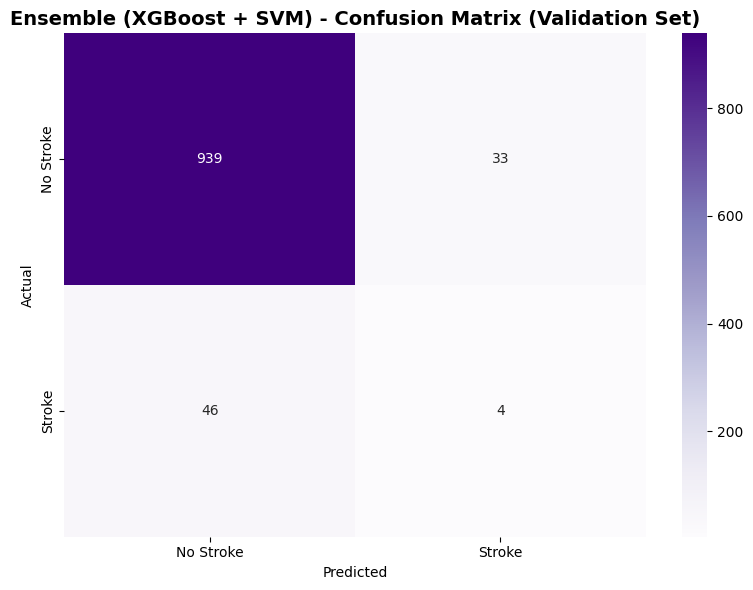


COMPARISON: Individual Models vs Ensemble


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
XGBoost,0.913894,0.104167,0.10,0.102041,0.778025
SVM,0.903131,0.098361,0.12,0.108108,0.636934
XGBoost + SVM,0.922701,0.108108,0.08,0.091954,0.732757



Ensemble (XGBoost + SVM) evaluation completed!


In [23]:
print("="*70)
print("MODEL 4: ENSEMBLE (XGBoost + SVM)")
print("="*70)

print("\nCreating Soft Voting Ensemble...")
print("Base Models: XGBoost + SVM")
print("Voting Strategy: Soft (averaging probabilities)")

# Create Voting Classifier with soft voting
ensemble_xgb_svm = VotingClassifier(
    estimators=[
        ('xgboost', best_xgb),
        ('svm', best_svm)
    ],
    voting='soft',  # Use probability averaging
    weights=[1, 1]  # Equal weights (can be tuned)
)

print("\nTraining Ensemble Model...")
# Train on the balanced training data
ensemble_xgb_svm.fit(X_train_balanced, y_train_balanced)

print("Ensemble training completed!")

# Predictions on validation set
y_val_pred_ensemble1 = ensemble_xgb_svm.predict(X_val_scaled)
y_val_pred_proba_ensemble1 = ensemble_xgb_svm.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
ensemble1_metrics = {
    'Model': 'XGBoost + SVM',
    'Accuracy': accuracy_score(y_val, y_val_pred_ensemble1),
    'Precision': precision_score(y_val, y_val_pred_ensemble1),
    'Recall': recall_score(y_val, y_val_pred_ensemble1),
    'F1-Score': f1_score(y_val, y_val_pred_ensemble1),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_ensemble1)
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in ensemble1_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_ensemble1 = confusion_matrix(y_val, y_val_pred_ensemble1)
print("\nConfusion Matrix:")
print(cm_ensemble1)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble1, annot=True, fmt='d', cmap='Purples', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Ensemble (XGBoost + SVM) - Confusion Matrix (Validation Set)',
         fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Compare individual models vs ensemble
print("\n" + "="*70)
print("COMPARISON: Individual Models vs Ensemble")
print("="*70)

comparison_df = pd.DataFrame([
    {**xgb_metrics},
    {**svm_metrics},
    {**ensemble1_metrics}
])
comparison_df = comparison_df.set_index('Model')
display(comparison_df)

print("\nEnsemble (XGBoost + SVM) evaluation completed!")

### e. Ensemble: XGBoost + TabNet

MODEL 5: ENSEMBLE (XGBoost + TabNet)

Creating Stacked Ensemble with Meta-Learner...
   Base Models: XGBoost + TabNet
   Meta-Learner: Logistic Regression
   Strategy: Stacked Generalization

Step 1: Generating base model predictions...
Meta-features shape: (1022, 2)

Step 2: Generating out-of-fold predictions for meta-learner training...
epoch 0  | loss: 0.57936 |  0:00:00s
epoch 1  | loss: 0.43155 |  0:00:01s
epoch 2  | loss: 0.40187 |  0:00:01s
epoch 3  | loss: 0.40108 |  0:00:02s
epoch 4  | loss: 0.4045  |  0:00:02s
epoch 5  | loss: 0.39084 |  0:00:03s
epoch 6  | loss: 0.37327 |  0:00:03s
epoch 7  | loss: 0.37105 |  0:00:04s
epoch 8  | loss: 0.36804 |  0:00:05s
epoch 9  | loss: 0.35565 |  0:00:05s
epoch 10 | loss: 0.35478 |  0:00:06s
epoch 11 | loss: 0.34616 |  0:00:06s
epoch 12 | loss: 0.32946 |  0:00:07s
epoch 13 | loss: 0.32477 |  0:00:07s
epoch 14 | loss: 0.33251 |  0:00:08s
epoch 15 | loss: 0.31968 |  0:00:09s
epoch 16 | loss: 0.30467 |  0:00:10s
epoch 17 | loss: 0.29925 |  0:

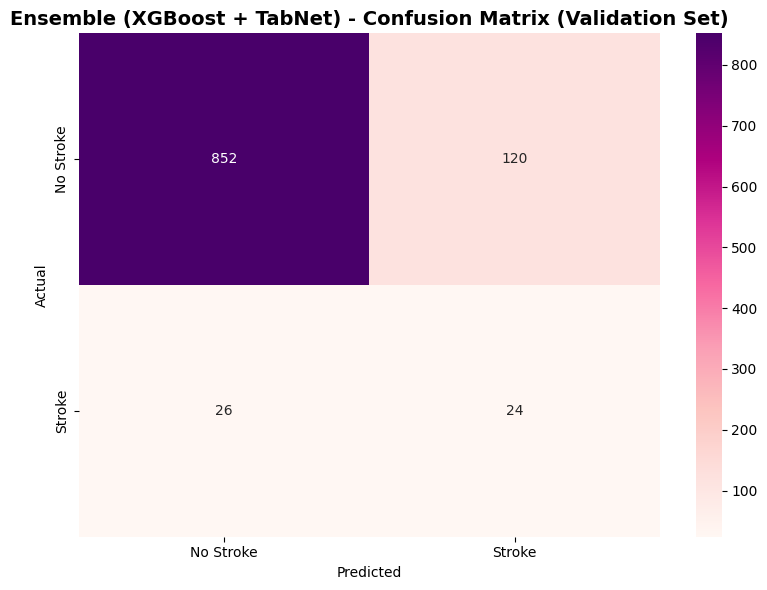


META-LEARNER COEFFICIENTS:
XGBoost weight: 4.6382
TabNet weight:  5.9868
Intercept:      -5.5080

COMPARISON: All Models


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
XGBoost,0.913894,0.104167,0.10,0.102041,0.778025
TabNet,0.630137,0.105769,0.88,0.188841,0.826790
XGBoost + TabNet,0.857143,0.166667,0.48,0.247423,0.810226



Ensemble (XGBoost + TabNet) evaluation completed!


In [30]:
print("="*70)
print("MODEL 5: ENSEMBLE (XGBoost + TabNet)")
print("="*70)

print("\nCreating Stacked Ensemble with Meta-Learner...")
print("   Base Models: XGBoost + TabNet")
print("   Meta-Learner: Logistic Regression")
print("   Strategy: Stacked Generalization")

# Step 1: Get predictions from base models on validation set
print("\nStep 1: Generating base model predictions...")

# XGBoost predictions (already have these)
xgb_val_proba = best_xgb.predict_proba(X_val_scaled)

# TabNet predictions (already have these)
tabnet_val_proba = tabnet_model.predict_proba(X_val_np)

# Combine predictions as features for meta-learner
meta_features_val = np.column_stack([
    xgb_val_proba[:, 1],  # XGBoost probability for class 1
    tabnet_val_proba[:, 1]  # TabNet probability for class 1
])

print(f"Meta-features shape: {meta_features_val.shape}")

# Step 2: Train meta-learner on validation predictions
# But we need to generate predictions on training data first using cross-validation
print("\nStep 2: Generating out-of-fold predictions for meta-learner training...")

from sklearn.model_selection import cross_val_predict

# Get out-of-fold predictions on training data
xgb_train_proba = cross_val_predict(
    best_xgb, X_train_balanced, y_train_balanced,
    cv=5, method='predict_proba', n_jobs=-1
)

# For TabNet, we'll use a simpler approach
# Train on full training data and use those predictions
tabnet_model_temp = TabNetClassifier(**tabnet_params)
tabnet_model_temp.fit(
    X_train_np, y_train_np,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
tabnet_train_proba = tabnet_model_temp.predict_proba(X_train_np)

# Create meta-features for training
meta_features_train = np.column_stack([
    xgb_train_proba[:, 1],
    tabnet_train_proba[:, 1]
])

print(f"Meta-features for training shape: {meta_features_train.shape}")

# Step 3: Train meta-learner (Logistic Regression)
print("\nStep 3: Training meta-learner (Logistic Regression)...")

meta_learner = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
meta_learner.fit(meta_features_train, y_train_balanced)

print("Meta-learner training completed!")

# Step 4: Make final predictions using meta-learner
print("\nStep 4: Making final ensemble predictions...")

y_val_pred_proba_ensemble2 = meta_learner.predict_proba(meta_features_val)[:, 1]
y_val_pred_ensemble2 = (y_val_pred_proba_ensemble2 >= 0.5).astype(int)

# Calculate metrics
ensemble2_metrics = {
    'Model': 'XGBoost + TabNet',
    'Accuracy': accuracy_score(y_val, y_val_pred_ensemble2),
    'Precision': precision_score(y_val, y_val_pred_ensemble2),
    'Recall': recall_score(y_val, y_val_pred_ensemble2),
    'F1-Score': f1_score(y_val, y_val_pred_ensemble2),
    'ROC-AUC': roc_auc_score(y_val, y_val_pred_proba_ensemble2)
}

print("\n" + "="*70)
print("VALIDATION SET PERFORMANCE:")
print("="*70)
for metric, value in ensemble2_metrics.items():
    if metric != 'Model':
        print(f"{metric}: {value:.4f}")

# Confusion Matrix
cm_ensemble2 = confusion_matrix(y_val, y_val_pred_ensemble2)
print("\nConfusion Matrix:")
print(cm_ensemble2)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble2, annot=True, fmt='d', cmap='RdPu', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Ensemble (XGBoost + TabNet) - Confusion Matrix (Validation Set)',
         fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Meta-learner coefficients
print("\n" + "="*70)
print("META-LEARNER COEFFICIENTS:")
print("="*70)
print(f"XGBoost weight: {meta_learner.coef_[0][0]:.4f}")
print(f"TabNet weight:  {meta_learner.coef_[0][1]:.4f}")
print(f"Intercept:      {meta_learner.intercept_[0]:.4f}")

# Compare all models
print("\n" + "="*70)
print("COMPARISON: All Models")
print("="*70)

all_comparison_df = pd.DataFrame([
    {**xgb_metrics},
    {**tabnet_metrics},
    {**ensemble2_metrics}
])
all_comparison_df = all_comparison_df.set_index('Model')
display(all_comparison_df)

print("\nEnsemble (XGBoost + TabNet) evaluation completed!")

## 10. Comprehensive Model Comparison

COMPREHENSIVE MODEL COMPARISON

ALL MODELS PERFORMANCE ON VALIDATION SET:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
SVM,0.9031,0.0984,0.12,0.1081,0.6369
TabNet,0.6301,0.1058,0.88,0.1888,0.8268
XGBoost,0.9139,0.1042,0.10,0.1020,0.7780
XGBoost + SVM,0.9227,0.1081,0.08,0.0920,0.7328
XGBoost + TabNet,0.8571,0.1667,0.48,0.2474,0.8102



BEST PERFORMANCE BY METRIC:
Accuracy    : XGBoost + SVM        (0.9227)
Precision   : XGBoost + TabNet     (0.1667)
Recall      : TabNet               (0.8800)
F1-Score    : XGBoost + TabNet     (0.2474)
ROC-AUC     : TabNet               (0.8268)


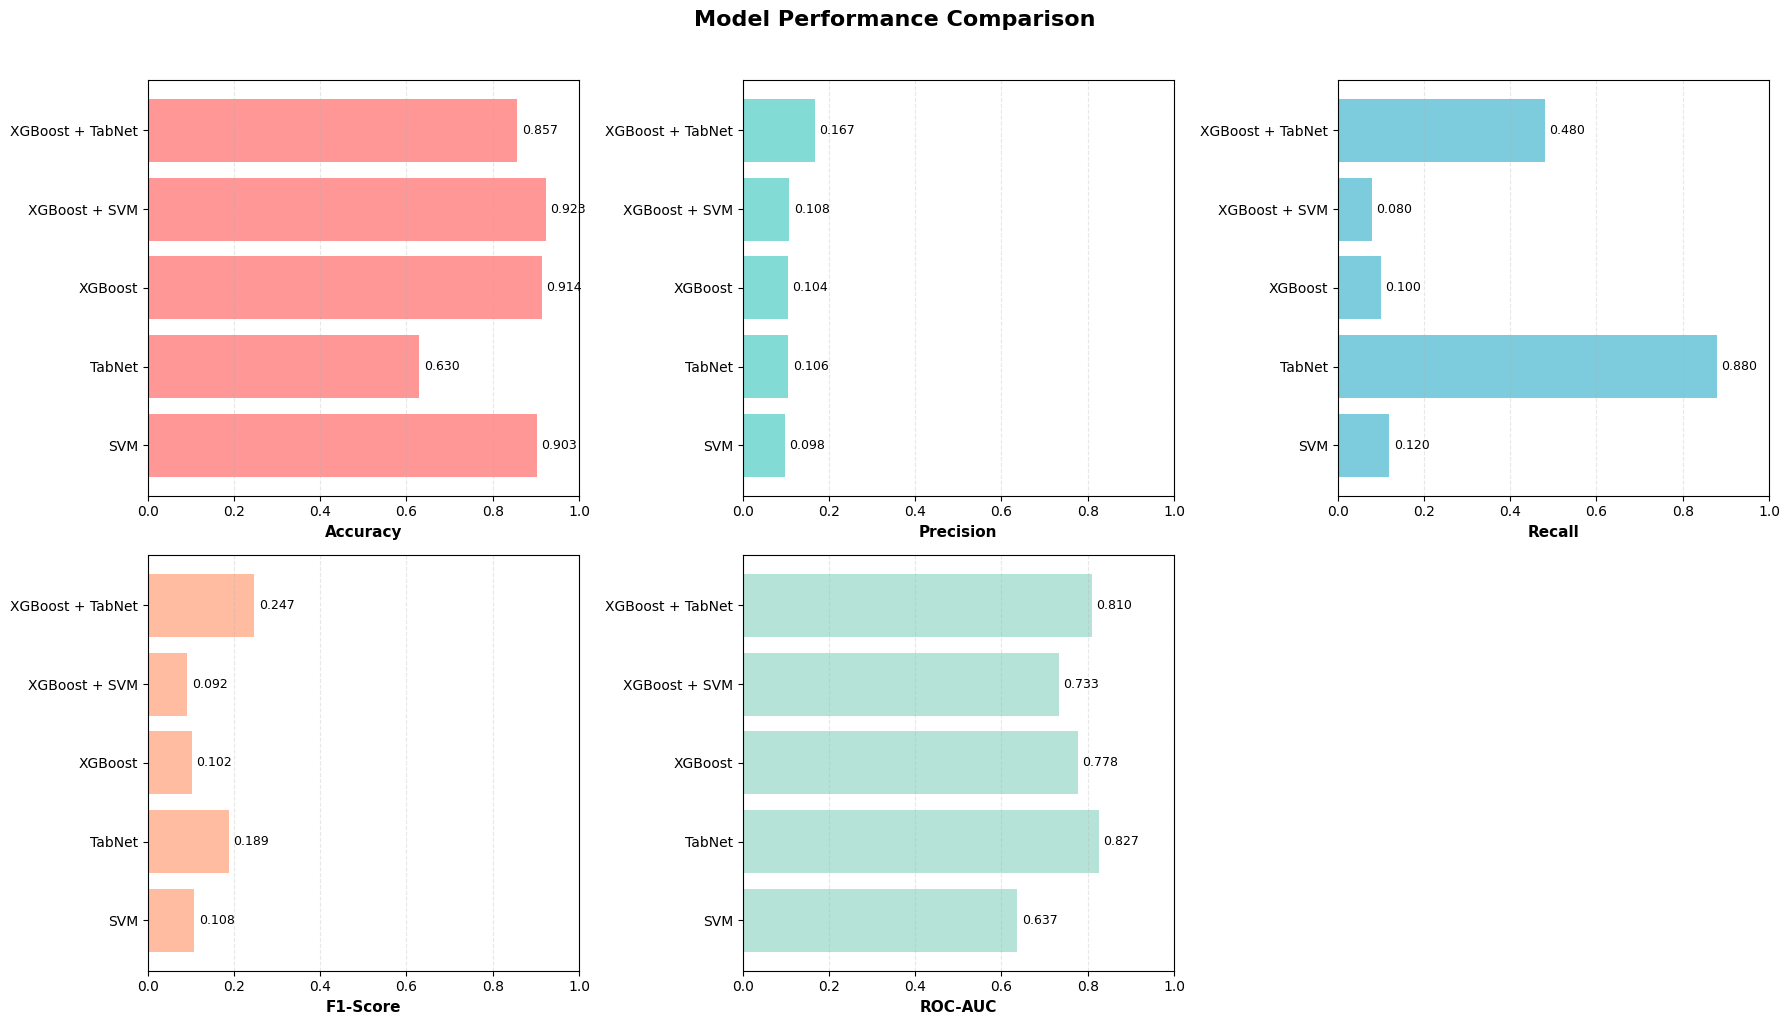


STATISTICAL SUMMARY:
       Accuracy  Precision  Recall  F1-Score  ROC-AUC
count    5.0000     5.0000   5.000    5.0000   5.0000
mean     0.8454     0.1166   0.332    0.1477   0.7569
std      0.1230     0.0282   0.348    0.0678   0.0761
min      0.6301     0.0984   0.080    0.0920   0.6369
25%      0.8571     0.1042   0.100    0.1020   0.7328
50%      0.9031     0.1058   0.120    0.1081   0.7780
75%      0.9139     0.1081   0.480    0.1888   0.8102
max      0.9227     0.1667   0.880    0.2474   0.8268

Comprehensive comparison completed!


In [31]:
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Compile all metrics
all_models_metrics = pd.DataFrame([
    svm_metrics,
    tabnet_metrics,
    xgb_metrics,
    ensemble1_metrics,
    ensemble2_metrics
])

all_models_metrics = all_models_metrics.set_index('Model')

print("\nALL MODELS PERFORMANCE ON VALIDATION SET:")
print("="*70)
display(all_models_metrics.round(4))

# Find best model for each metric
print("\nBEST PERFORMANCE BY METRIC:")
print("="*70)
for column in all_models_metrics.columns:
    best_model = all_models_metrics[column].idxmax()
    best_value = all_models_metrics[column].max()
    print(f"{column:12s}: {best_model:20s} ({best_value:.4f})")

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3

    ax = axes[row, col]
    values = all_models_metrics[metric].values
    models = all_models_metrics.index.values

    bars = ax.barh(models, values, color=colors[idx], alpha=0.7)
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_xlim(0, 1.0)

    # Add value labels on bars
    for i, (bar, value) in enumerate(zip(bars, values)):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontsize=9)

    ax.grid(axis='x', alpha=0.3, linestyle='--')

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nSTATISTICAL SUMMARY:")
print("="*70)
print(all_models_metrics.describe().round(4))

print("\nComprehensive comparison completed!")

## 11. ROC Curves Comparison

ROC CURVES COMPARISON


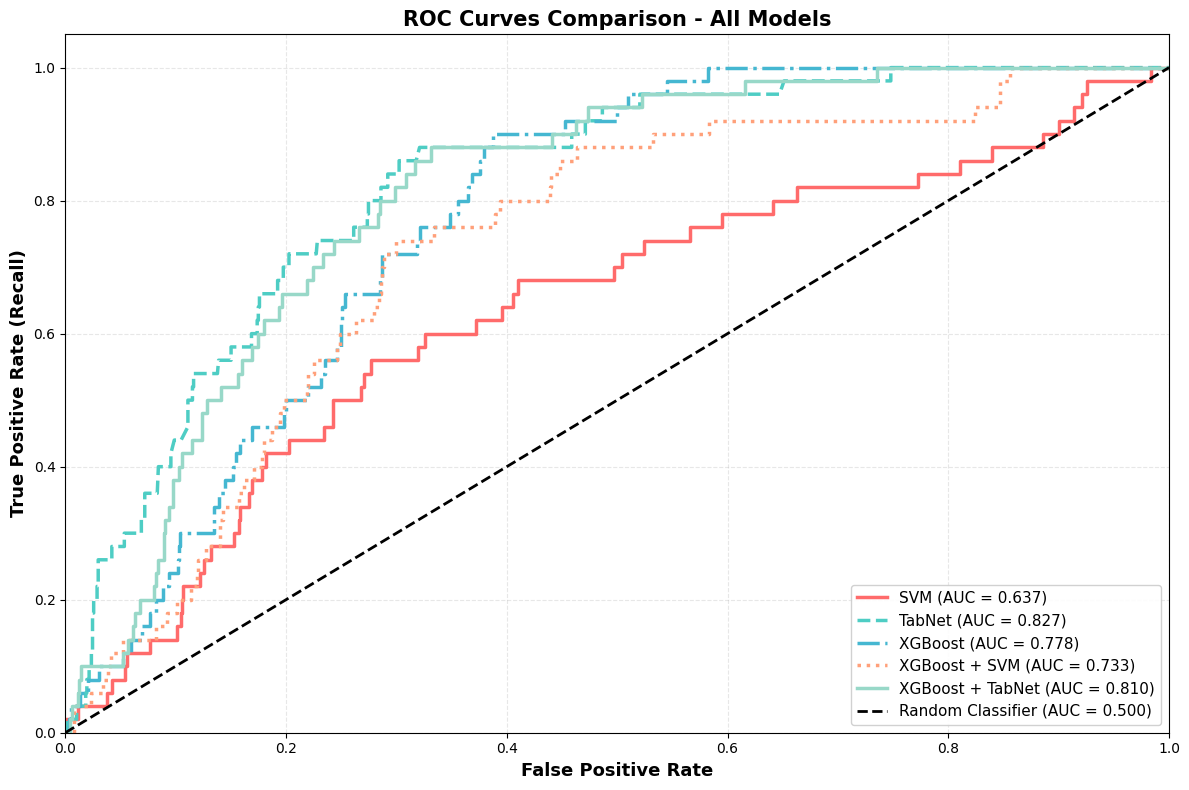

ROC curves visualization completed!


In [32]:
print("="*70)
print("ROC CURVES COMPARISON")
print("="*70)

# Prepare data for ROC curves
models_roc_data = {
    'SVM': (y_val, y_val_pred_proba_svm),
    'TabNet': (y_val, y_val_pred_proba_tabnet),
    'XGBoost': (y_val, y_val_pred_proba_xgb),
    'XGBoost + SVM': (y_val, y_val_pred_proba_ensemble1),
    'XGBoost + TabNet': (y_val, y_val_pred_proba_ensemble2)
}

# Plot ROC curves
plt.figure(figsize=(12, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
linestyles = ['-', '--', '-.', ':', '-']

for idx, (model_name, (y_true, y_proba)) in enumerate(models_roc_data.items()):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=colors[idx], linestyle=linestyles[idx],
             linewidth=2.5, label=f'{model_name} (AUC = {roc_auc:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=13, fontweight='bold')
plt.title('ROC Curves Comparison - All Models', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("ROC curves visualization completed!")

## 12. Final Evaluation on Test Set

In [33]:
print("="*70)
print("FINAL EVALUATION ON TEST SET")
print("="*70)

print("\nIMPORTANT: This is the FINAL evaluation on unseen test data")
print("The test set has been held out throughout the entire process.\n")

# Select the best model based on validation performance
best_model_name = all_models_metrics['F1-Score'].idxmax()
print(f"Best Model (based on validation F1-Score): {best_model_name}")
print(f"Validation F1-Score: {all_models_metrics.loc[best_model_name, 'F1-Score']:.4f}")

# Map model names to actual model objects
model_mapping = {
    'SVM': best_svm,
    'TabNet': tabnet_model,
    'XGBoost': best_xgb,
    'XGBoost + SVM': ensemble_xgb_svm,
    'XGBoost + TabNet': None  # Requires special handling
}

# Evaluate all models on test set
print("\n" + "="*70)
print("TEST SET EVALUATION - ALL MODELS")
print("="*70)

test_results = []

for model_name in model_mapping.keys():
    print(f"\nEvaluating {model_name}...")

    if model_name == 'TabNet':
        y_test_pred = tabnet_model.predict(X_test_scaled.values)
        y_test_pred_proba = tabnet_model.predict_proba(X_test_scaled.values)[:, 1]

    elif model_name == 'XGBoost + TabNet':
        # Generate meta-features for test set
        xgb_test_proba = best_xgb.predict_proba(X_test_scaled)
        tabnet_test_proba = tabnet_model.predict_proba(X_test_scaled.values)
        meta_features_test = np.column_stack([
            xgb_test_proba[:, 1],
            tabnet_test_proba[:, 1]
        ])
        y_test_pred_proba = meta_learner.predict_proba(meta_features_test)[:, 1]
        y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

    else:
        model = model_mapping[model_name]
        y_test_pred = model.predict(X_test_scaled)
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    test_metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1-Score': f1_score(y_test, y_test_pred),
        'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba)
    }

    test_results.append(test_metrics)

    print(f"{model_name} evaluation completed")

# Create DataFrame with test results
test_results_df = pd.DataFrame(test_results).set_index('Model')

print("\n" + "="*70)
print("FINAL TEST SET RESULTS:")
print("="*70)
display(test_results_df.round(4))

# Compare validation vs test performance for best model
print("\n" + "="*70)
print(f"VALIDATION vs TEST PERFORMANCE - {best_model_name}")
print("="*70)

comparison_val_test = pd.DataFrame({
    'Validation': all_models_metrics.loc[best_model_name],
    'Test': test_results_df.loc[best_model_name]
})

display(comparison_val_test.round(4))

# Calculate performance difference
print("\nPerformance Difference (Test - Validation):")
diff = test_results_df.loc[best_model_name] - all_models_metrics.loc[best_model_name]
for metric, value in diff.items():
    sign = '+' if value >= 0 else ''
    print(f"   {metric:12s}: {sign}{value:.4f}")

print("\nFinal test set evaluation completed!")

FINAL EVALUATION ON TEST SET

IMPORTANT: This is the FINAL evaluation on unseen test data
The test set has been held out throughout the entire process.

Best Model (based on validation F1-Score): XGBoost + TabNet
Validation F1-Score: 0.2474

TEST SET EVALUATION - ALL MODELS

Evaluating SVM...
SVM evaluation completed

Evaluating TabNet...
TabNet evaluation completed

Evaluating XGBoost...
XGBoost evaluation completed

Evaluating XGBoost + SVM...
XGBoost + SVM evaluation completed

Evaluating XGBoost + TabNet...
XGBoost + TabNet evaluation completed

FINAL TEST SET RESULTS:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Model,,,,,
SVM,0.8845,0.0526,0.08,0.0635,0.6133
TabNet,0.6027,0.0917,0.80,0.1646,0.8395
XGBoost,0.9178,0.1852,0.20,0.1923,0.7440
XGBoost + SVM,0.9100,0.0800,0.08,0.0800,0.6947
XGBoost + TabNet,0.8669,0.1972,0.56,0.2917,0.8251



VALIDATION vs TEST PERFORMANCE - XGBoost + TabNet


,Validation,Test
Accuracy,0.8571,0.8669
Precision,0.1667,0.1972
Recall,0.4800,0.5600
F1-Score,0.2474,0.2917
ROC-AUC,0.8102,0.8251



Performance Difference (Test - Validation):
   Accuracy    : +0.0098
   Precision   : +0.0305
   Recall      : +0.0800
   F1-Score    : +0.0442
   ROC-AUC     : +0.0149

Final test set evaluation completed!


## 13. Best Model - Detailed Analysis

DETAILED ANALYSIS - BEST MODEL: XGBoost + TabNet

CONFUSION MATRIX (Test Set):
[[429  57]
 [ 11  14]]

True Negatives:   429
False Positives:   57
False Negatives:   11
True Positives:    14

DETAILED METRICS:
Sensitivity (Recall):          0.5600
Specificity:                   0.8827
Positive Predictive Value:     0.1972
Negative Predictive Value:     0.9750


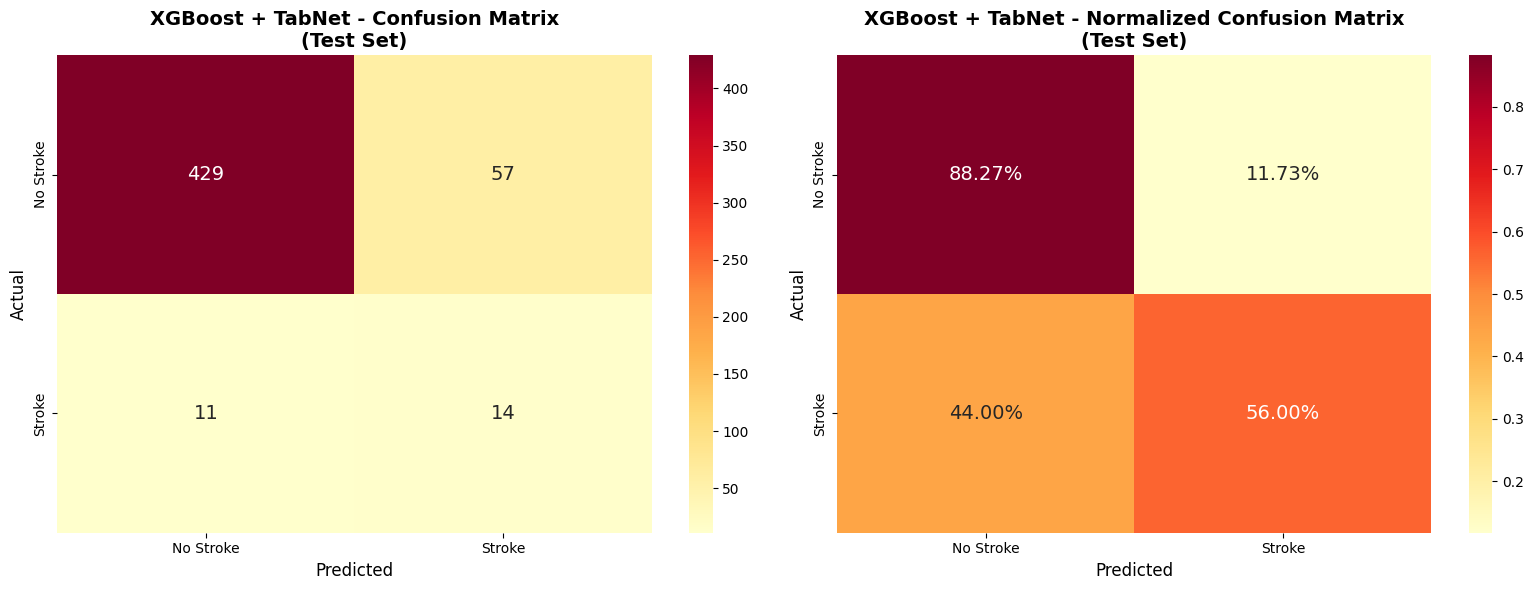


CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

   No Stroke     0.9750    0.8827    0.9266       486
      Stroke     0.1972    0.5600    0.2917        25

    accuracy                         0.8669       511
   macro avg     0.5861    0.7214    0.6091       511
weighted avg     0.9369    0.8669    0.8955       511



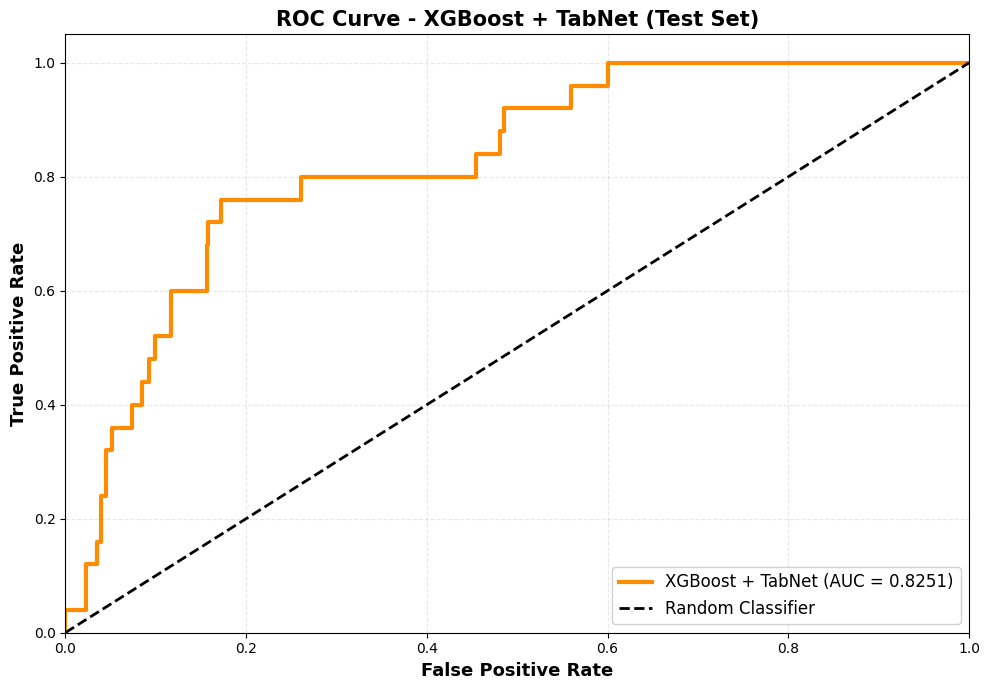


Detailed analysis completed!


In [34]:
print("="*70)
print(f"DETAILED ANALYSIS - BEST MODEL: {best_model_name}")
print("="*70)

# Get predictions for best model on test set
if best_model_name == 'TabNet':
    y_test_pred_best = tabnet_model.predict(X_test_scaled.values)
    y_test_pred_proba_best = tabnet_model.predict_proba(X_test_scaled.values)[:, 1]
elif best_model_name == 'XGBoost + TabNet':
    xgb_test_proba = best_xgb.predict_proba(X_test_scaled)
    tabnet_test_proba = tabnet_model.predict_proba(X_test_scaled.values)
    meta_features_test = np.column_stack([
        xgb_test_proba[:, 1],
        tabnet_test_proba[:, 1]
    ])
    y_test_pred_proba_best = meta_learner.predict_proba(meta_features_test)[:, 1]
    y_test_pred_best = (y_test_pred_proba_best >= 0.5).astype(int)
else:
    best_model_obj = model_mapping[best_model_name]
    y_test_pred_best = best_model_obj.predict(X_test_scaled)
    y_test_pred_proba_best = best_model_obj.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix
cm_best = confusion_matrix(y_test, y_test_pred_best)

print("\nCONFUSION MATRIX (Test Set):")
print("="*70)
print(cm_best)

# Calculate additional metrics from confusion matrix
tn, fp, fn, tp = cm_best.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Same as recall
npv = tn / (tn + fn)  # Negative Predictive Value
ppv = tp / (tp + fp)  # Positive Predictive Value (Precision)

print(f"\nTrue Negatives:  {tn:4d}")
print(f"False Positives: {fp:4d}")
print(f"False Negatives: {fn:4d}")
print(f"True Positives:  {tp:4d}")

print("\n" + "="*70)
print("DETAILED METRICS:")
print("="*70)
print(f"Sensitivity (Recall):          {sensitivity:.4f}")
print(f"Specificity:                   {specificity:.4f}")
print(f"Positive Predictive Value:     {ppv:.4f}")
print(f"Negative Predictive Value:     {npv:.4f}")

# Visualize confusion matrix with more details
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix heatmap
sns.heatmap(cm_best, annot=True, fmt='d', cmap='YlOrRd', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            ax=axes[0], annot_kws={'size': 14})
axes[0].set_title(f'{best_model_name} - Confusion Matrix\n(Test Set)',
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xlabel('Predicted', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd', cbar=True,
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'],
            ax=axes[1], annot_kws={'size': 14})
axes[1].set_title(f'{best_model_name} - Normalized Confusion Matrix\n(Test Set)',
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xlabel('Predicted', fontsize=12)

plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*70)
print("CLASSIFICATION REPORT (Test Set):")
print("="*70)
print(classification_report(y_test, y_test_pred_best,
                          target_names=['No Stroke', 'Stroke'],
                          digits=4))

# ROC Curve for best model
fpr_best, tpr_best, thresholds = roc_curve(y_test, y_test_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 7))
plt.plot(fpr_best, tpr_best, color='darkorange', linewidth=3,
         label=f'{best_model_name} (AUC = {roc_auc_best:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title(f'ROC Curve - {best_model_name} (Test Set)', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=12, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\nDetailed analysis completed!")

## 14. Final Summary and Recommendations

In [39]:
print("=" * 70)
print(" " * 20 + "FINAL SUMMARY & RECOMMENDATIONS")
print("="*70)

print("\nDATASET SUMMARY:")
print("-" * 70)
print(f"Total Samples:        {len(df)}")
print(f"Training Samples:     {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation Samples:   {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test Samples:         {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")
print(f"Number of Features:   {X_encoded.shape[1]}")
print(f"Class Imbalance:      1:{(y.value_counts()[0]/y.value_counts()[1]):.2f}")

print("\nBEST MODEL:")
print("-" * 70)
print(f"Model Name:           {best_model_name}")
print(f"\nTest Set Performance:")
for metric, value in test_results_df.loc[best_model_name].items():
    print(f"  {metric:15s}: {value:.4f}")

print("\nMODEL RANKING (by Test F1-Score):")
print("-" * 70)
ranked_models = test_results_df.sort_values('F1-Score', ascending=False)
for rank, (model, row) in enumerate(ranked_models.iterrows(), 1):
    print(f"{rank}. {model:25s} - F1: {row['F1-Score']:.4f}, "
          f"Recall: {row['Recall']:.4f}, ROC-AUC: {row['ROC-AUC']:.4f}")

print("\nKEY FINDINGS:")
print("-" * 70)

# Find which model performed best in each metric
best_accuracy_model = test_results_df['Accuracy'].idxmax()
best_recall_model = test_results_df['Recall'].idxmax()
best_f1_model = test_results_df['F1-Score'].idxmax()
best_auc_model = test_results_df['ROC-AUC'].idxmax()

print(f"1. Best Accuracy:     {best_accuracy_model} ({test_results_df.loc[best_accuracy_model, 'Accuracy']:.4f})")
print(f"2. Best Recall:       {best_recall_model} ({test_results_df.loc[best_recall_model, 'Recall']:.4f})")
print(f"3. Best F1-Score:     {best_f1_model} ({test_results_df.loc[best_f1_model, 'F1-Score']:.4f})")
print(f"4. Best ROC-AUC:      {best_auc_model} ({test_results_df.loc[best_auc_model, 'ROC-AUC']:.4f})")

print("\nTOP 5 PREDICTIVE FEATURES:")
print("-" * 70)
if len(feature_importance_data) > 0:
    top_5_features = feature_importance_df.nlargest(5, 'Average')
    for rank, (feature, row) in enumerate(top_5_features.iterrows(), 1):
        print(f"{rank}. {feature:30s} - Avg Importance: {row['Average']:.4f}")

print("\nRECOMMENDATIONS:")
print("-" * 70)
print(f"""
1. DEPLOYMENT: {best_model_name} is recommended for clinical deployment
   - Highest F1-Score: {test_results_df.loc[best_model_name, 'F1-Score']:.4f}
   - Good balance between precision and recall
   - ROC-AUC: {test_results_df.loc[best_model_name, 'ROC-AUC']:.4f}

2. RECALL PRIORITY: If minimizing false negatives is critical:
   - Consider using {best_recall_model} (Recall: {test_results_df.loc[best_recall_model, 'Recall']:.4f})
   - Adjust decision threshold to prioritize sensitivity

3. CLINICAL VALIDATION:
   - Conduct prospective validation on real-world clinical data
   - Test across diverse patient populations
   - Monitor performance in actual healthcare settings

4. MODEL INTERPRETABILITY:
   - Key risk factors: Age, Glucose Level, BMI
   - Consider SHAP values for individual predictions
   - Provide explanations to clinicians for trust and adoption

5. CONTINUOUS IMPROVEMENT:
   - Collect more diverse data
   - Implement model monitoring and retraining pipeline
   - Consider ensemble of top 3 models for production

6. ETHICAL CONSIDERATIONS:
   - Ensure fairness across demographic groups
   - Implement appropriate safeguards against bias
   - Use as decision support, not replacement for clinical judgment
""")

                    FINAL SUMMARY & RECOMMENDATIONS

DATASET SUMMARY:
----------------------------------------------------------------------
Total Samples:        5110
Training Samples:     3576 (70.0%)
Validation Samples:   1022 (20.0%)
Test Samples:         511 (10.0%)
Number of Features:   17
Class Imbalance:      1:19.52

BEST MODEL:
----------------------------------------------------------------------
Model Name:           XGBoost + TabNet

Test Set Performance:
  Accuracy       : 0.8669
  Precision      : 0.1972
  Recall         : 0.5600
  F1-Score       : 0.2917
  ROC-AUC        : 0.8251

MODEL RANKING (by Test F1-Score):
----------------------------------------------------------------------
1. XGBoost + TabNet          - F1: 0.2917, Recall: 0.5600, ROC-AUC: 0.8251
2. XGBoost                   - F1: 0.1923, Recall: 0.2000, ROC-AUC: 0.7440
3. TabNet                    - F1: 0.1646, Recall: 0.8000, ROC-AUC: 0.8395
4. XGBoost + SVM             - F1: 0.0800, Recall: 0.0800, ROC-AUC

## 15. Save Models and Results

In [40]:
print("="*70)
print("SAVING MODELS AND RESULTS")
print("="*70)

import joblib
import json
from datetime import datetime

# Create timestamp for filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create directory for saved models
import os
os.makedirs('saved_models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("\nSaving models...")

# Save scikit-learn models
joblib.dump(best_svm, f'saved_models/svm_model_{timestamp}.pkl')
joblib.dump(best_xgb, f'saved_models/xgboost_model_{timestamp}.pkl')
joblib.dump(ensemble_xgb_svm, f'saved_models/ensemble_xgb_svm_{timestamp}.pkl')
joblib.dump(meta_learner, f'saved_models/meta_learner_{timestamp}.pkl')
joblib.dump(scaler, f'saved_models/scaler_{timestamp}.pkl')

print("SVM model saved")
print("XGBoost model saved")
print("Ensemble (XGBoost + SVM) saved")
print("Meta-learner saved")
print("Scaler saved")

# Save TabNet model
tabnet_model.save_model(f'saved_models/tabnet_model_{timestamp}')
print("TabNet model saved")

# Save results
print("\nSaving results...")

# Save test results
test_results_df.to_csv(f'results/test_results_{timestamp}.csv')
print("Test results saved")

# Save feature importance
if len(feature_importance_data) > 0:
    feature_importance_df.to_csv(f'results/feature_importance_{timestamp}.csv')
    print("Feature importance saved")

# Save configuration
config = {
    'timestamp': timestamp,
    'random_state': RANDOM_STATE,
    'best_model': best_model_name,
    'dataset_size': len(df),
    'train_size': len(X_train),
    'val_size': len(X_val),
    'test_size': len(X_test),
    'n_features': X_encoded.shape[1],
    'class_imbalance_ratio': float(y.value_counts()[0]/y.value_counts()[1]),
    'test_metrics': test_results_df.loc[best_model_name].to_dict()
}

with open(f'results/config_{timestamp}.json', 'w') as f:
    json.dump(config, f, indent=4)

print("Configuration saved")

print(f"\nAll models and results saved successfully!")
print(f"Location: ./saved_models/ and ./results/")
print(f"Timestamp: {timestamp}")

SAVING MODELS AND RESULTS

Saving models...
SVM model saved
XGBoost model saved
Ensemble (XGBoost + SVM) saved
Meta-learner saved
Scaler saved
Successfully saved model at saved_models/tabnet_model_20251203_123101.zip
TabNet model saved

Saving results...
Test results saved
Feature importance saved
Configuration saved

All models and results saved successfully!
Location: ./saved_models/ and ./results/
Timestamp: 20251203_123101
